# LV-Localized UQ — Tests for Case_1 / Case_2 / Case_3

This notebook runs three datasets (the order is not the same as in the paper; they are cases 2,3,4 in the paper):

- **Case_1** → Soil Moisture Hyperspectral Image Dataset (selected pixels)
- **Case_2** → LeafMassArea (LMA) Hyperspectral Image Dataset (selected pixels)
- **Case_3** → Corn Spectral Dataset (Laboratory)

For each case, in this demo we run:

1) **Baseline linear PLS**  
2) **Kernel PLS (KPLS)** with fixed kernel parameters  
3) **Kernel PLS (KPLS) + KernelFlow (KF)** optimized kernel parameters  

We then plot:
- KF running loss (if KF ran)
- Predictions with (1−α) prediction intervals
- qHistory heatmap (intervals × LVs)
- |residual| vs q
- coverage bar plot

CITE: Duma, Z.-S., Lamminpää, O., Susiluoto, J., Haario, H., Zheng, T.,
Sihvonen, T., Braverman, A., Townsend, P. A., Reinikainen, S.-P.
(2025).\
*Uncertainty calibration for latent-variable regression models.*\
arXiv:2512.23444v1.

In [ ]:
using Random, Statistics, LinearAlgebra
using Plots

include("refactored_UC_functions.jl")
using .LVLocalizedUQ

function check_required_files()
    req = [
        ("Case_1 (GermanyHyper)", "soilMoisture.mat"),
        ("Case_2 (newShiftData)", "shiftNewData.mat"),
        ("Case_3 (Corn spectra)", "corn_spectra.xlsx"),
        ("Case_3 (Corn props)",  "corn_propvals.xlsx"),
    ]
    for (label, path) in req
        if !isfile(path)
            @warn "Missing file for $label" path=path
        end
    end
end

check_required_files()

## Hyperparameters 

### Common
- `testSize`: fraction of samples held out as the final test set
- `alpha`: miscoverage level. `alpha=0.05` means target 95% coverage intervals
- `dim`: number of latent variables (LVs) used by PLS/KPLS
- `ni`: number of LV-score bins per LV for localized calibration

### Kernel (used by KPLS/KPCR)
- `kernelType`: kernel function (`"gaussian"`, `"cauchy"`, `"matern1/2"`, `"matern3/2"`, `"matern5/2"`)
- `kernelVersion`: parameterization style
  - `"combined"`: one global lengthscale (plus ridge)
  - `"individual"`: one lengthscale per feature
  - `"individualScale"`: lengthscale + amplitude per feature
  - `"family"`: additive mixture kernel

### KernelFlow (KF) optimization
- `do_kf`: must be **Bool** `true/false` (NOT `:true` which is a Symbol!)
- `kf_iter`: number of optimization steps
- `learnRate`: gradient step size
- `sp`: subsampling proportion
- `nsamp`: number of subsamples (used by one loss variant)
- `loss`: which KF loss to use (1 or 2) 1 = from [1]. 2 = from [2]
- `kf_pls`: KF-internal setting (`"SIMPLS"`, `"PCR"`, etc.)
- `initialParams`: initial kernel parameters in log-space (KF applies `exp.(param)` internally)

In [ ]:
function make_figs(m::Dict{Symbol,Any}; do_kf::Bool=false, title_prefix::String="")
    figs = Dict{Symbol,Any}()

    α = m[:alpha]
    target = 1 - α

    # standardized quantities
    yhat = vec(m[:yPredTest])
    y    = vec(m[:Ytest])
    q    = vec(m[:qTest])

    lo = yhat .- q
    hi = yhat .+ q
    abs_resid = abs.(yhat .- y)

    covered = (y .>= lo) .& (y .<= hi)
    emp_cov = mean(covered)

    # KF loss
    if do_kf && haskey(m, :kf_lossHistory)
        figs[:kf_loss] = plot(vec(m[:kf_lossHistory]), lw=2,
                              xlabel="Iteration", ylabel="Loss",
                              title="$(title_prefix)KF running loss",
                              legend=false)
    end

    # qHistory heatmap
    if haskey(m, :qHistory)
        qH = m[:qHistory]
        k, H = size(qH)
        figs[:qHistory] = heatmap(1:H, 1:k, qH,
                                  xlabel="LV (h)", ylabel="Interval (i)",
                                  title="$(title_prefix)qHistory (intervals × LVs)",
                                  yflip=false)
    end

    # Predictions with PI bands (sorted by prediction)
    ord = sortperm(yhat)
    p_pi = plot(1:length(ord), yhat[ord], label="pred",
                xlabel="Test sample (sorted)", ylabel="y (standardized)",
                title="$(title_prefix)Predictions with $(round(Int,100*target))% PI")
    plot!(p_pi, 1:length(ord), lo[ord], label="PI lower")
    plot!(p_pi, 1:length(ord), hi[ord], label="PI upper")
    scatter!(p_pi, 1:length(ord), y[ord], label="true", ms=3)
    figs[:pi] = p_pi

    # |residual| vs q
    p_rvq = scatter(q, abs_resid, ms=4,
                    xlabel="Estimated q (PI half-width)",
                    ylabel="|ŷ − y|",
                    title="$(title_prefix)|residual| vs q",
                    legend=false)
    xmin = min(minimum(q), minimum(abs_resid))
    xmax = max(maximum(q), maximum(abs_resid))
    plot!(p_rvq, [xmin, xmax], [xmin, xmax], lw=2, label=false)
    figs[:resid_vs_q] = p_rvq

    # Coverage bar
    figs[:coverage] = bar(["covered","missed"], [sum(covered), sum(.!covered)],
                          ylabel="Count",
                          title="$(title_prefix)Coverage: emp=$(round(emp_cov,digits=3)) target=$(round(target,digits=3))",
                          legend=false)
    
                          p_sc = scatter(y, yhat;
                   yerror=q,
                   ms=4,
                   xlabel="y true (standardized)",
                   ylabel="y pred (standardized)",
                   title="$(title_prefix)True vs Pred with $(round(Int,100*target))% PI whiskers",
                   label=false)

    # 1:1 reference line
    lo_all = min(minimum(y), minimum(yhat .- q))
    hi_all = max(maximum(y), maximum(yhat .+ q))
    plot!(p_sc, [lo_all, hi_all], [lo_all, hi_all], lw=2, label=false)

    figs[:ytrue_ypred_whiskers] = p_sc

    return figs
end

# Case mapping
const CASES = Dict(
    "Case_1" => "GermanyHyper",
    "Case_2" => "newShiftData",
    "Case_3" => "Corn",
)

function base_model(dataset::String; rngseed::Int=1,
                    dim::Int=5, ni::Int=5, alpha::Float64=0.05, testSize::Float64=0.2,
                    kernelType::String="cauchy", kernelVersion::String="combined")
    rng = MersenneTwister(rngseed)

    model = Dict{Symbol,Any}(
        :dataset => dataset,
        :method  => "PLS",
        :dim     => dim,
        :ni      => ni,
        :alpha   => alpha,
        :testSize => testSize,
        :rng     => rng,
        :filtering => false,
        :smoothWindow => 5,
        :kernelType => kernelType,
        :kernelVersion => kernelVersion,
        :kernelParams => [1.0, 1e-6],  # default for combined: [ℓ, ridge]
    )

    if dataset == "newShiftData"
        model[:dataSubset] = "LMA"
        model[:selectedBands] = Int[]
    elseif dataset == "Corn"
        model[:cornTargetCol] = 1
    end

    return model
end

"""
run_case(case_id; ...)

- method: "PLS" or "KPLS" (etc.)
- do_kf: Bool (true/false)
- kernelType/kernelVersion: forwarded to both KPLS and KF
- initialParams: KF log-params (KF uses exp.(param))
"""
function run_case(case_id::String;
                  method::String="PLS",
                  do_kf::Bool=false,

                  dim::Int=5,
                  ni::Int=5,
                  alpha::Float64=0.05,
                  testSize::Float64=0.2,

                  kernelType::String="cauchy",
                  kernelVersion::String="combined",

                  # KF knobs
                  kf_iter::Int=500,
                  learnRate::Float64=0.2,
                  sp::Float64=0.3,
                  nsamp::Int=5,
                  loss::Int=2,
                  kf_pls::String="SIMPLS",
                  initialParams::Vector{Float64}=[log(1.0), log(1e-6)],

                  rngseed::Int=1)

    dataset = CASES[case_id]
    model = base_model(dataset; rngseed=rngseed, dim=dim, ni=ni, alpha=alpha, testSize=testSize,
                       kernelType=kernelType, kernelVersion=kernelVersion)
    model[:method] = method

    # load/split/standardize
    X, y = LVLocalizedUQ.load_raw_data(model)
    X = LVLocalizedUQ.preprocess(X, model)
    Xtr, ytr, Xte, yte = LVLocalizedUQ.split_train_test(X, y; testSize=testSize, rng=model[:rng])

    model[:X] = Xtr
    model[:Y] = reshape(ytr, :, 1)
    model[:Xtest] = Xte
    model[:Ytest] = reshape(yte, :, 1)

    LVLocalizedUQ.standardize!(model)

    # Optional KF
    if do_kf
        # IMPORTANT: do_kf must be Bool, not Symbol (true/false, not :true)
        model[:iter] = kf_iter
        model[:learnRate] = learnRate
        model[:sp] = sp
        model[:nsamp] = nsamp
        model[:loss] = loss
        model[:PLS] = kf_pls
        model[:initialParams] = Float64.(initialParams)

        LVLocalizedUQ.learn_kernel_params!(model)
    end

    out = LVLocalizedUQ.conformal_uq!(model)
    figs = make_figs(out; do_kf=do_kf, title_prefix="$(case_id) :: ")

    return out, figs
end

run_case

## Run A — Baseline linear PLS for all cases

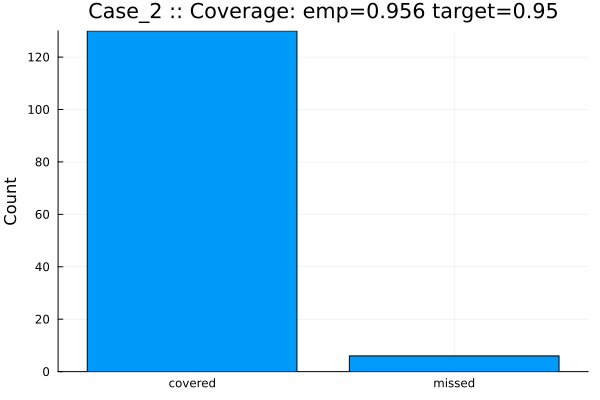

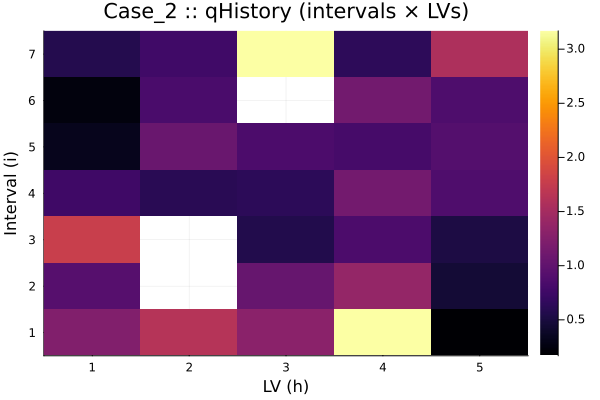

Case_2 :: coverage
Case_2 :: qHistory
Case_2 :: ytrue_ypred_whiskers
Case_2 :: resid_vs_q
Case_2 :: pi
Case_3 :: coverage
Case_3 :: qHistory
Case_3 :: ytrue_ypred_whiskers
Case_3 :: resid_vs_q
Case_3 :: pi
Case_4 :: coverage
Case_4 :: qHistory
Case_4 :: ytrue_ypred_whiskers
Case_4 :: resid_vs_q
Case_4 :: pi


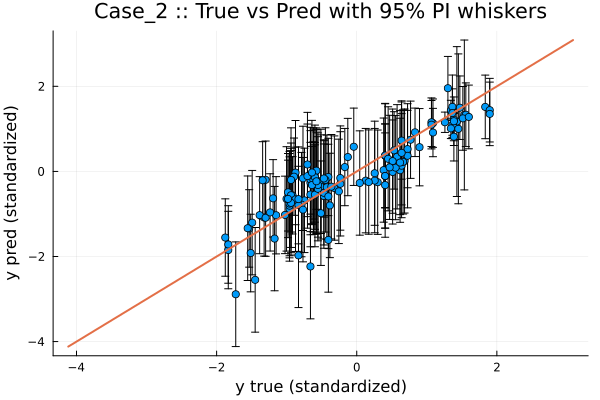

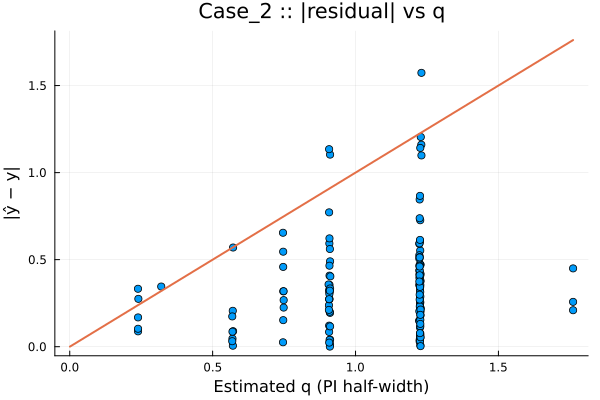

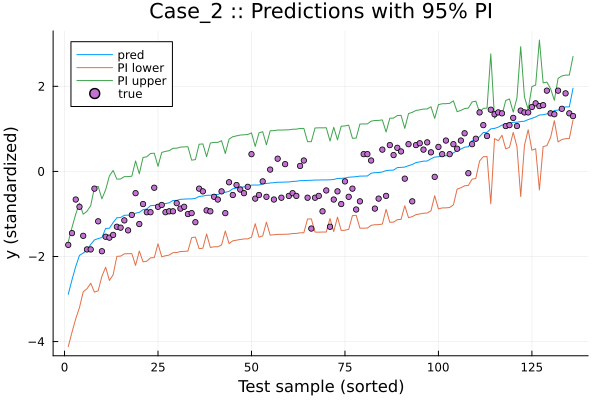

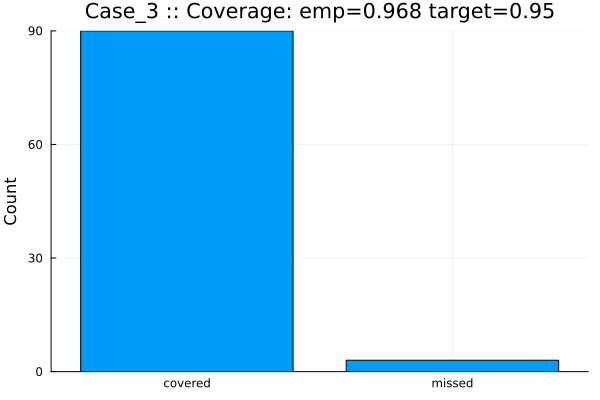

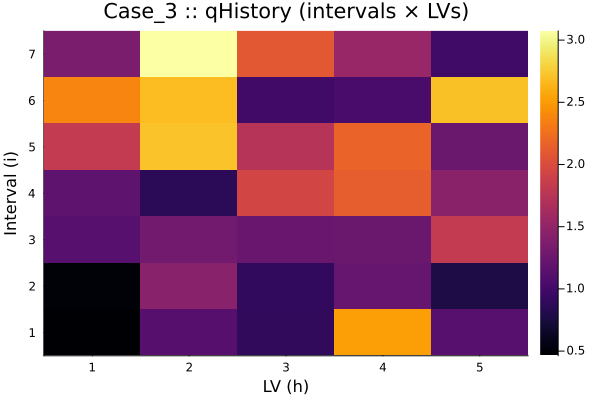

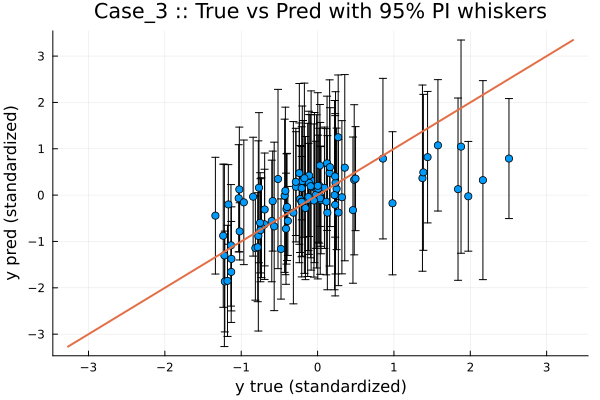

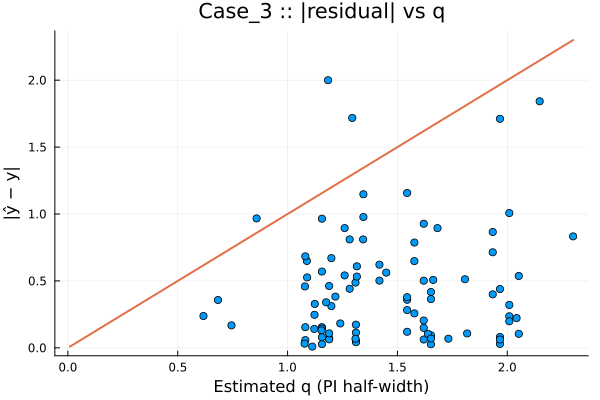

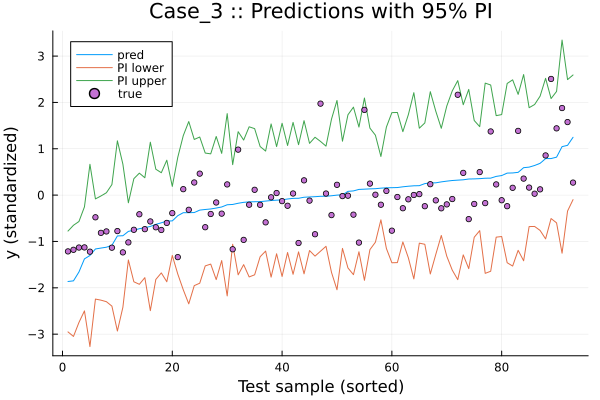

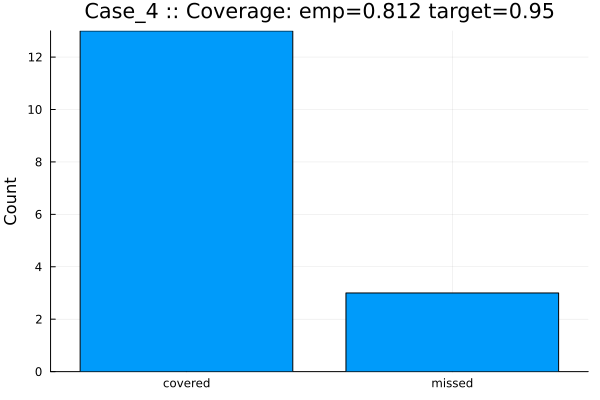

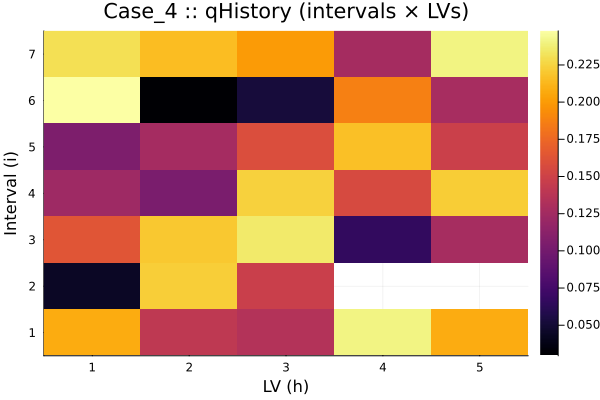

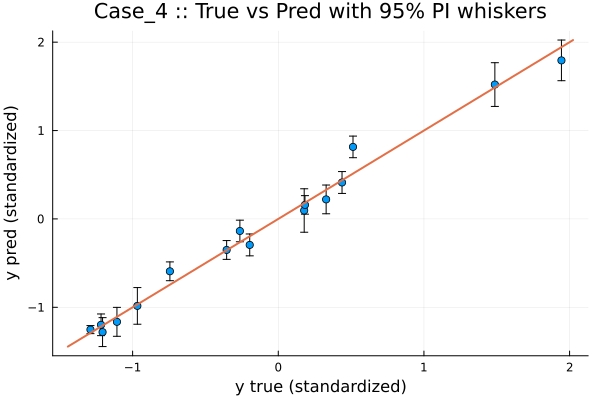

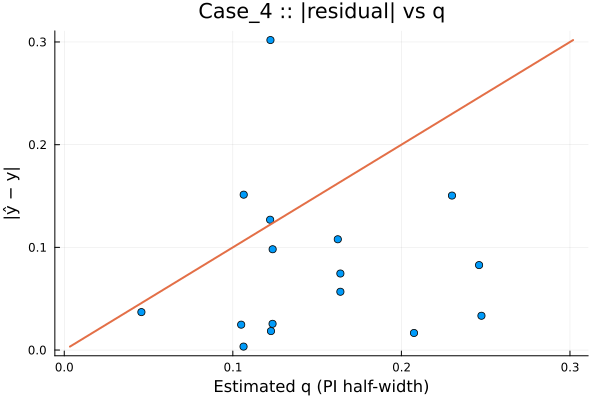

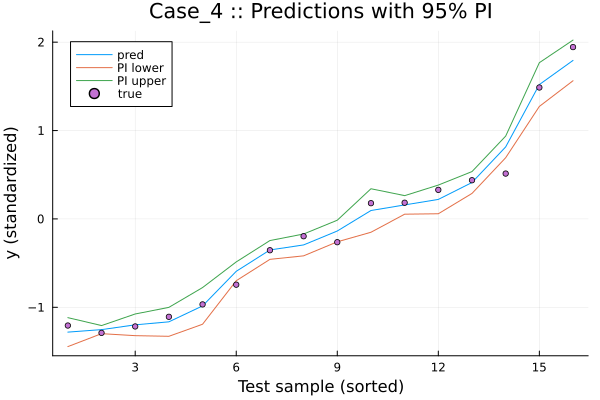

In [57]:
cases = ["Case_2","Case_3","Case_4"]

results_pls = Dict{String,Any}()

for c in cases
    try
        out, figs = run_case(c; method="PLS", do_kf=false, dim=5, ni=7, alpha=0.05, testSize=0.2, rngseed=1)
        results_pls[c] = out

        for (name, p) in figs
            println(c, " :: ", name)
            display(p)
        end
    catch e
        @warn "Case $c failed (PLS baseline)" exception=(e, catch_backtrace())
    end
end

## Run B — KPLS + KernelFlow (KF)

For `kernelVersion="combined"` we optimize 2 params:
- `ℓ` (lengthscale)
- `ridge` (regularization)

We pass `initialParams=[log(ℓ0), log(ridge0)]` and KF uses `exp.(param)` internally.

If you switch to `"individual"` / `"individualScale"` / `"family"`, you must supply the correct-length `initialParams`.

In [59]:
results_kpls_kf = Dict{String,Any}()

function run_one_case!(results::Dict{String,Any}, c::String;
    dim=5, ni=5, alpha=0.05, testSize=0.2,
    kernelType="cauchy", kernelVersion="combined",
    kf_iter=2000, learnRate=0.2, sp=0.3, nsamp=5, loss=2, kf_pls="SIMPLS"
)
    try
        out, figs = run_case(c; method="KPLS", do_kf=true,
            dim=dim, ni=ni, alpha=alpha, testSize=testSize,
            kernelType=kernelType, kernelVersion=kernelVersion,
            kf_iter=kf_iter, learnRate=learnRate, sp=sp, nsamp=nsamp, loss=loss, kf_pls=kf_pls
        )

        results[c] = out

        for (name, p) in figs
            println(c, " :: ", name)
            display(p)
        end

        return out, figs
    catch e
        @warn "Case $c failed (KPLS + KF)" exception=(e, catch_backtrace())
        return nothing, nothing
    end
end

run_one_case! (generic function with 1 method)

1
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990
1000
1010
1020
1030
1040
1050
1060
1070
1080
1090
1100
1110
1120
1130
1140
1150
1160
1170
1180
1190
1200
1210
1220
1230
1240
1250
1260
1270
1280
1290
1300
1310
1320
1330
1340
1350
1360
1370
1380
1390
1400
1410
1420
1430
1440
1450
1460
1470
1480
1490
1500
1510
1520
1530
1540
1550
1560
1570
1580
1590
1600
1610
1620
1630
1640
1650
1660
1670
1680
1690
1700
1710
1720
1730
1740
1750
1760
1770
1780
1790
1800
1810
1820
1830
1840
1850
1860
1870
1880
1890
1900
1910
1920
1930
1940
1950
1960
1970
1980
1990
2000
Case_4 :: coverage
Case_4 :: qHistory
Case_4 :: ytrue_ypred_whiskers
Case_4 :: resid_vs_q
Case_4 :: kf_los

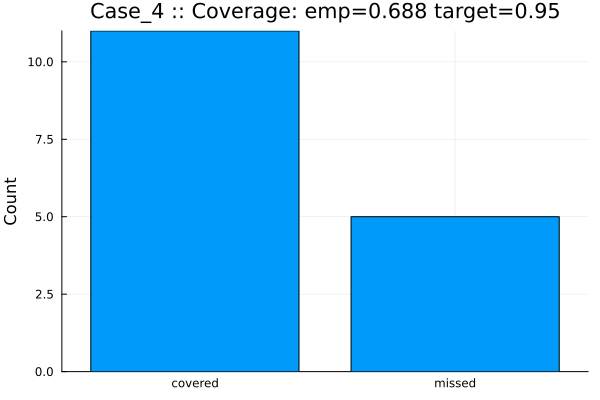

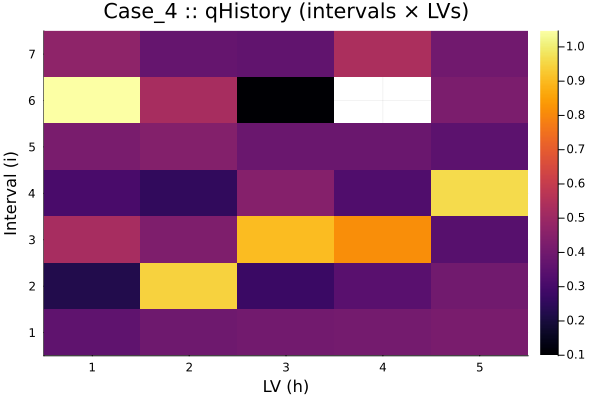

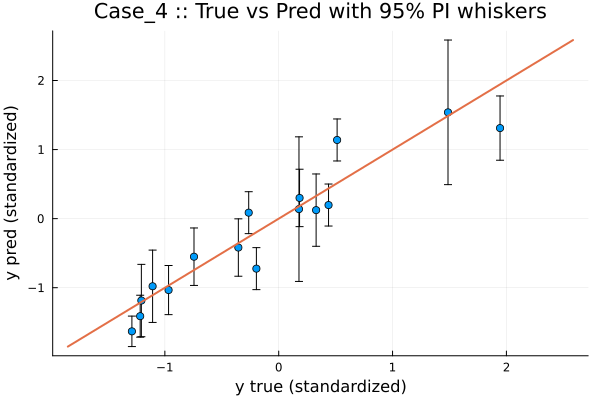

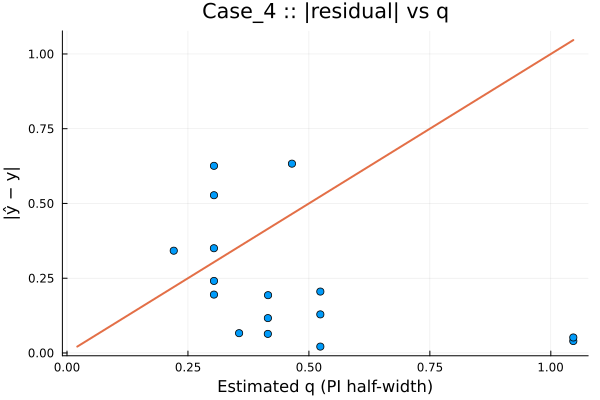

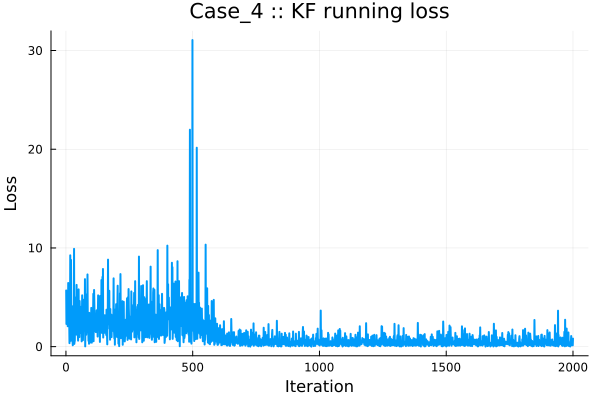

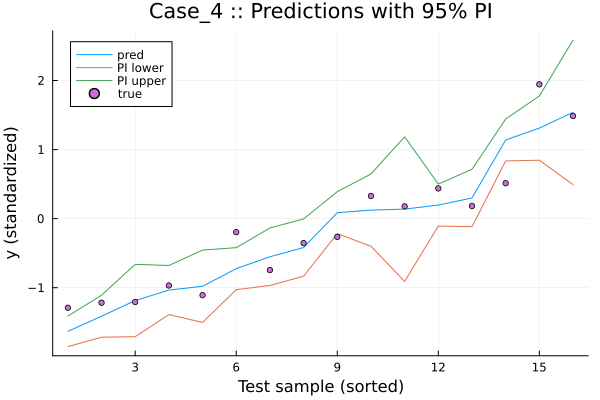

(Dict{Symbol, Any}(:lv_weights => [0.999368153699755, 0.0006203333589433143, 1.1042750911883042e-5, 3.2761207854327955e-7, 1.4257831106183964e-7], :alpha => 0.05, :XTrain_uq => [-1.6990913691094733 -1.6957352818520446 … -1.079254030377008 -1.0741756926898351; -0.9883878750258824 -0.9812098120155057 … -1.234496883877405 -1.2322201414469285; … ; 0.5092863792291793 0.5141629500827694 … -0.1661469247994781 -0.1648812264638103; 0.9938355368893008 0.9911468435816274 … 1.6491692724999791 1.653147264680591], :ni => 7, :sp => 0.3, :testSize => 0.2, :idxSamp => Matrix{Float64}(undef, 6, 0), :qHistory => [0.35562452762817737 0.39104973683087896 … 0.4037541656895283 0.4153737524427686; 0.22020306526662403 0.9438968448002757 … 0.3398838894634553 0.3971467256824249; … ; 1.0468790773211418 0.524755097424283 … NaN 0.42130113657999496; 0.46467694259694037 0.369168034135694 … 0.534172048002369 0.39645426181111837], :initialParams => [0.0, -13.815510557964274], :X => [2.1657574311665466 2.156186158536127

In [63]:
c = "Case_4"
run_one_case!(results_kpls_kf, c;
    kernelType="cauchy", kernelVersion="combined",
    kf_iter=2000, learnRate=0.2, sp=0.3, nsamp=5, loss=2, kf_pls="SIMPLS", dim=5, ni=7
)

1
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990
1000
1010
1020
1030
1040
1050
1060
1070
1080
1090
1100
1110
1120
1130
1140
1150
1160
1170
1180
1190
1200
1210
1220
1230
1240
1250
1260
1270
1280
1290
1300
1310
1320
1330
1340
1350
1360
1370
1380
1390
1400
1410
1420
1430
1440
1450
1460
1470
1480
1490
1500
1510
1520
1530
1540
1550
1560
1570
1580
1590
1600
1610
1620
1630
1640
1650
1660
1670
1680
1690
1700
1710
1720
1730
1740
1750
1760
1770
1780
1790
1800
1810
1820
1830
1840
1850
1860
1870
1880
1890
1900
1910
1920
1930
1940
1950
1960
1970
1980
1990
2000
Case_3 :: coverage
Case_3 :: qHistory
Case_3 :: ytrue_ypred_whiskers
Case_3 :: resid_vs_q
Case_3 :: kf_los

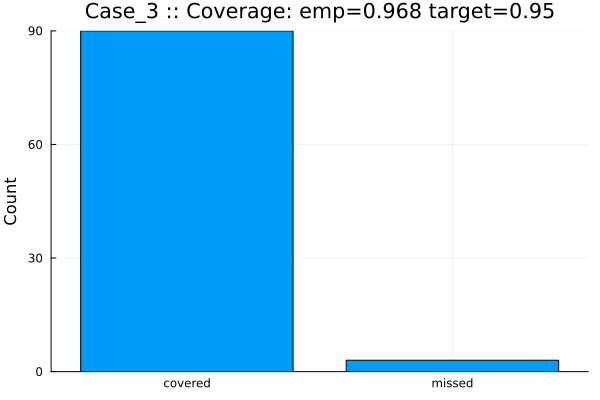

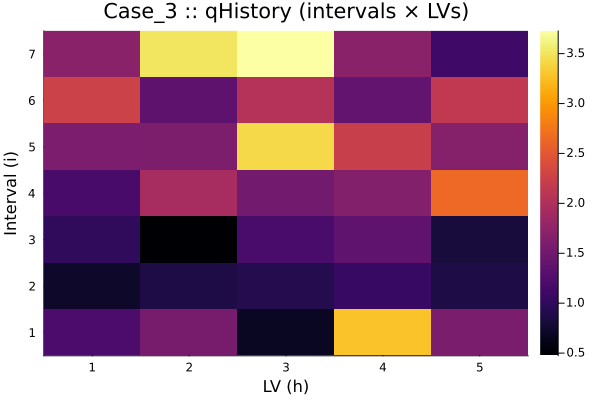

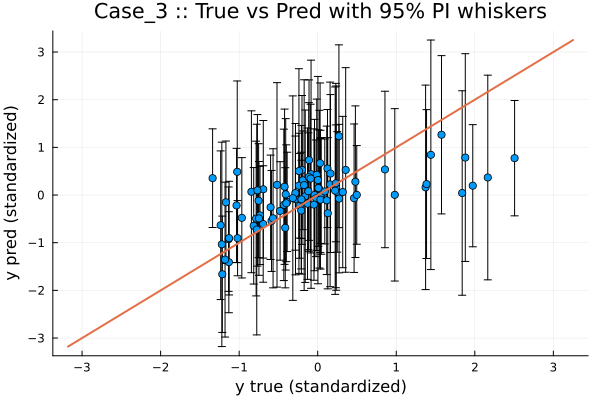

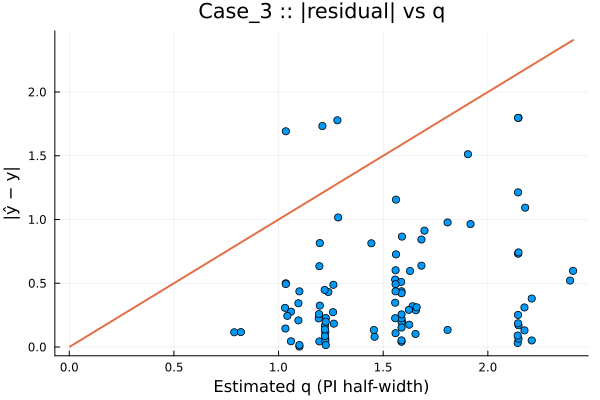

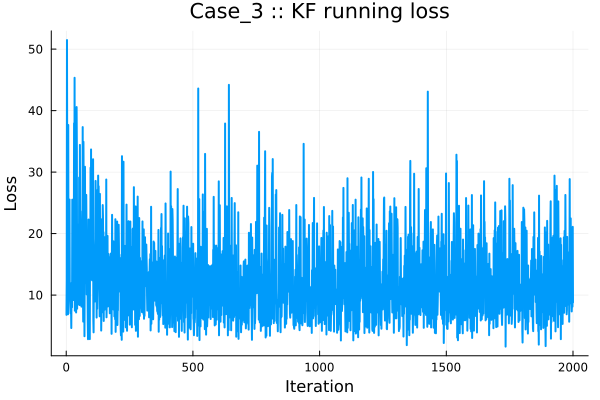

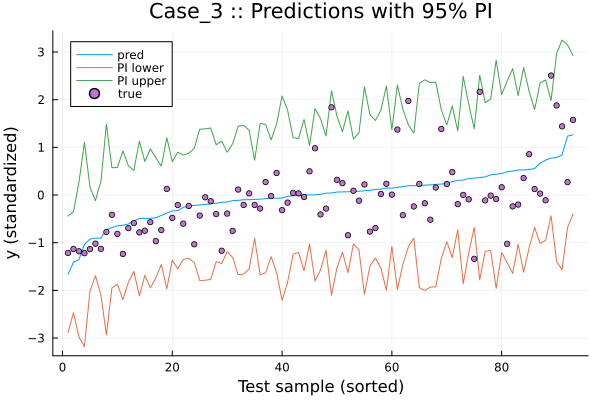

(Dict{Symbol, Any}(:lv_weights => [0.8786853735979072, 0.11475509831150532, 0.0064640467958863145, 2.5341909103673038e-5, 7.013938559721656e-5], :alpha => 0.05, :selectedBands => Int64[], :XTrain_uq => [0.10583152661906224 0.6743682339393136 … -0.5005814832697815 -0.048478360318343676; -1.5439102354079555 0.5140054782379114 … 0.8469532386547944 0.9113739543413789; … ; -1.4050085562460688 0.2424463348360743 … 0.2910882698727866 0.9750795831073299; 0.6642904495595021 -0.6424819811258401 … -1.0941317903206955 -0.9156287668192185], :ni => 7, :sp => 0.3, :testSize => 0.2, :idxSamp => Matrix{Float64}(undef, 34, 0), :qHistory => [1.2030457818702582 1.5450970965897108 … 3.274869042962755 1.5814849085564708; 0.7162038850160053 0.860294224297078 … 1.0468181128999703 0.8614295218855154; … ; 2.2557512778326423 1.346153138667054 … 1.3800955876035172 2.144316740940796; 1.6979603320526302 3.5114075251013 … 1.698919762733768 1.1058738155898031], :initialParams => [0.0, -13.815510557964274]…), Dict{Sym

In [64]:
c = "Case_3"
run_one_case!(results_kpls_kf, c;
    kernelType="cauchy", kernelVersion="combined",
    kf_iter=2000, learnRate=0.2, sp=0.3, nsamp=5, loss=2, kf_pls="SIMPLS", dim=5, ni=7
)

1
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990
1000
1010
1020
1030
1040
1050
1060
1070
1080
1090
1100
1110
1120
1130
1140
1150
1160
1170
1180
1190
1200
1210
1220
1230
1240
1250
1260
1270
1280
1290
1300
1310
1320
1330
1340
1350
1360
1370
1380
1390
1400
1410
1420
1430
1440
1450
1460
1470
1480
1490
1500
1510
1520
1530
1540
1550
1560
1570
1580
1590
1600
1610
1620
1630
1640
1650
1660
1670
1680
1690
1700
1710
1720
1730
1740
1750
1760
1770
1780
1790
1800
1810
1820
1830
1840
1850
1860
1870
1880
1890
1900
1910
1920
1930
1940
1950
1960
1970
1980
1990
2000
Case_2 :: coverage
Case_2 :: qHistory
Case_2 :: ytrue_ypred_whiskers
Case_2 :: resid_vs_q
Case_2 :: kf_los

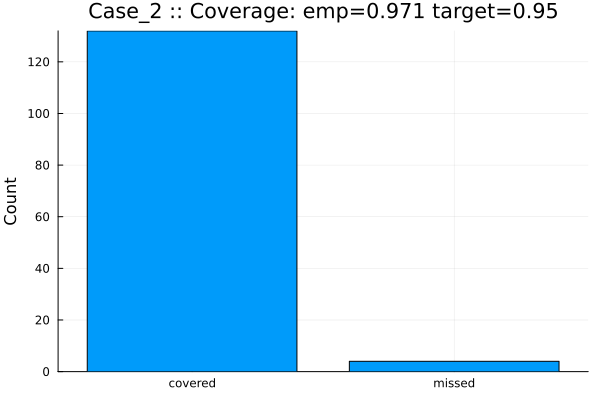

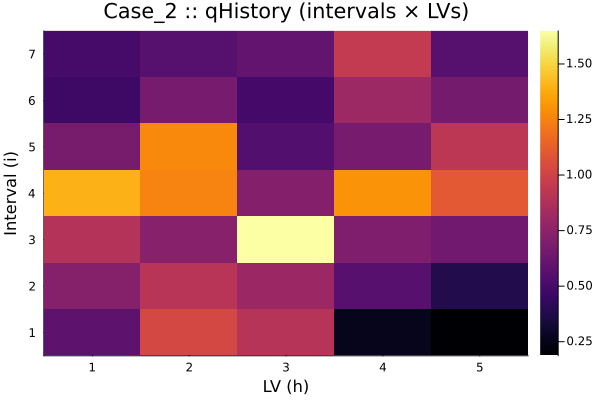

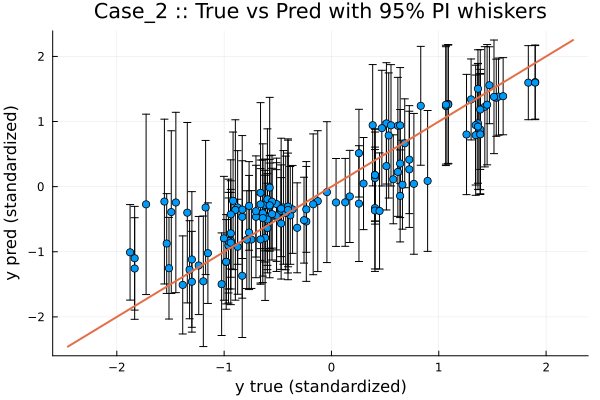

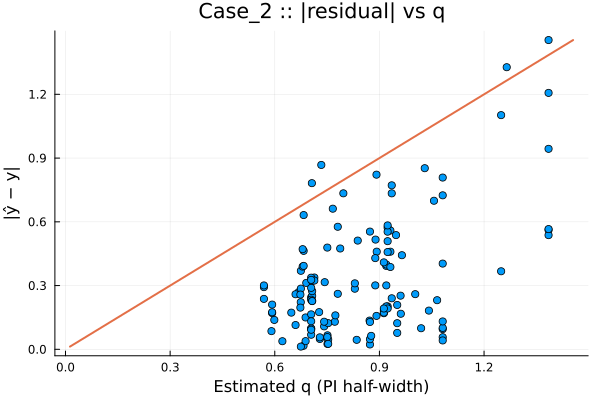

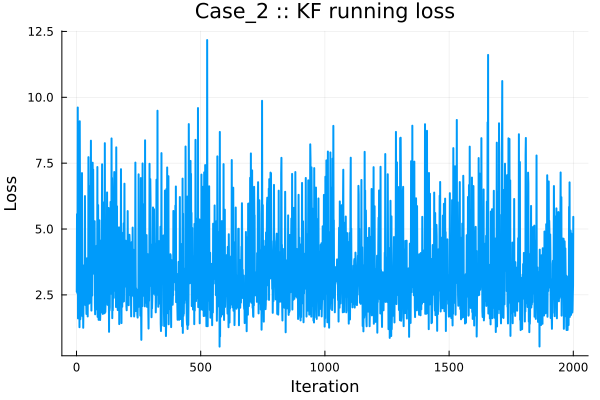

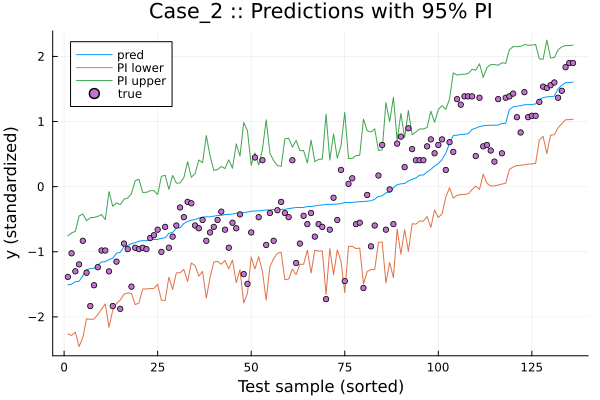

(Dict{Symbol, Any}(:lv_weights => [0.24968424395190572, 0.40460820118530566, 0.24622354895869408, 0.06407499530727558, 0.03540901059681867], :alpha => 0.05, :XTrain_uq => [-0.19562532848056116 -0.21972543991936147 … 0.13184870648003177 0.1167490393372331; -1.4185776506789471 -1.0857045186829395 … -0.8817074244882598 -0.9126419027997192; … ; -0.44569959825233596 -0.49983102503257676 … -0.46831648343399246 -0.4364145884172706; -0.7271549943389167 -0.8892762170726322 … -0.9968730108199528 -1.0106062223652035], :ni => 7, :sp => 0.3, :testSize => 0.2, :idxSamp => Matrix{Float64}(undef, 49, 0), :qHistory => [0.5744822737345611 1.01992062159992 … 0.25655111482465126 0.18663657819563736; 0.7189497940292838 0.9051479729461156 … 0.55227721662237 0.3743462488583903; … ; 0.46280652586734483 0.6642604699421064 … 0.8062039921972961 0.658403972073726; 0.49417400275330403 0.5498769539447762 … 0.9468548377773895 0.5506290781604748], :initialParams => [0.0, -13.815510557964274], :X => [-0.75988753482960

In [65]:
c = "Case_2"
run_one_case!(results_kpls_kf, c;
    kernelType="cauchy", kernelVersion="combined",
    kf_iter=2000, learnRate=0.2, sp=0.3, nsamp=5, loss=2, kf_pls="SIMPLS", dim=5, ni=7
)